In [1]:
from collections import OrderedDict, namedtuple
import time

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import theano as th
import theano.tensor as T

%load_ext autoreload
%autoreload 2

In [2]:
from utils.cartpole import CartPole
from utils import VariableStore, Linear, SGD, momentum

In [3]:
seed = int(time.time())
print seed
rng = T.shared_randomstreams.RandomStreams(seed)

1445884558


In [4]:
STATE_DIM = 4
ACTION_DIM = 1
EXPLORE_RANGE = 0.5

Critic = namedtuple("Critic", ["pred", "targets", "cost", "updates"])


class DPGModel(object):
    
    def __init__(self, state_dim, action_dim, explore_range=0.5, name="dpg"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.explore_range = explore_range
        self.name = name
        
        self._vs_actor = VariableStore("%s/vs_a" % name)
        self._vs_critic = VariableStore("%s/vs_c" % name)
        
        self._make_vars()
        self._make_graph()
        self._make_updates()
        self._make_functions()
        
    def _make_vars(self):
        self.X = T.matrix("X")

        # Optionally directly provide actions predicted
        self.actions = T.matrix("actions")
        # Q target values
        self.q_targets = T.vector("q_targets")
        # Learning rate
        self.lr = T.scalar("lr")
        
    def _make_graph(self):
        # Deterministic policy: linear map
        self.a_pred = Linear(self.X, self.state_dim, self.action_dim,
                             self._vs_actor)

        # Exploration policy: add noise
        self.a_explore = self.a_pred + rng.uniform(self.a_pred.shape,
                                                   -self.explore_range,
                                                   self.explore_range, ndim=2)

        # Critic 1: actions given
        self.critic_given = self._make_critic(self.actions, self.q_targets)
        # Critic 2: with deterministic policy
        self.critic_det = self._make_critic(self.a_pred, self.q_targets)
        # Critic 3: with noised / exploration policy
        self.critic_exp = self._make_critic(self.a_explore, self.q_targets)
        
    def _make_critic(self, actions, targets):
        q_pred = Linear(T.concatenate([self.X, actions], axis=1),
                        self.state_dim + self.action_dim, 1, self._vs_critic,
                        "%s/q" % self.name)
        q_pred = q_pred.reshape((-1,))
        q_cost = ((targets - q_pred) ** 2).mean()
        q_updates = momentum(q_cost, self._vs_critic.vars.values(), self.lr)
        return Critic(q_pred, targets, q_cost, q_updates)
    
    def _make_updates(self):
        # Actor-critic learning w/ critic 3
        # NB, need to flatten all timesteps into a single batch
        self.updates = OrderedDict(self.critic_exp.updates)
        # Add policy gradient updates
        self.updates.update(momentum(-self.critic_exp.pred.mean(),
                                     self._vs_actor.vars.values(),
                                     self.lr))
        
    def _make_functions(self):
        # On-policy action prediction function
        self.f_action_on = th.function([self.X], self.a_pred)
        # Off-policy action prediction function
        self.f_action_off = th.function([self.X], self.a_explore)

        # Q-function
        self.f_q = th.function([self.X, self.actions], self.critic_given.pred)

        # Actor-critic update
        self.f_update = th.function([self.X, self.q_targets, self.lr],
                                    (self.critic_exp.cost, self.critic_exp.pred),
                                    updates=self.updates)
        
        
dpg = DPGModel(STATE_DIM, ACTION_DIM, EXPLORE_RANGE)

In [5]:
def run_episode(f_onpolicy, f_offpolicy, f_q):
    """
    Simulate a trajectory and record states and rewards.
    Return a batch of (s, a, r, y), where `y` is a TD-learning error backup.
    """
    cp = CartPole()
    trace = cp.single_episode(policy=lambda *args: f_offpolicy(np.array(args).reshape((1, -1))))
    
    # states: list of s_t
    # actions: list of a_t = u(s_t)
    # rewards: list of r_t
    states, actions, rewards = [], [], []
    for state_t, action_t, reward_t, _, _ in trace:
        states.append(state_t)
        #print "action_t", action_t
        actions.append(0 if action_t < 0 else 1)
        rewards.append(reward_t)

    states, actions, rewards = np.array(states), np.array(actions).astype(np.int32), np.array(rewards)
    #rewards = rewards * 2 + 1
    
    return len(trace), states, actions, rewards

In [8]:
# Keep a replay buffer of states, actions, rewards, targets
R_states = np.empty((0, STATE_DIM), dtype=th.config.floatX)
R_actions = np.empty((0,), dtype=np.int32)
R_rewards = np.empty((0,), dtype=np.int32)

steps = []
q_costs = []

BATCH_SIZE = 50
LR = 0.01
GAMMA = 0.99

for t in xrange(500):
    steps_t, states_t, actions_t, rewards_t = run_episode(dpg.f_action_on, dpg.f_action_off, dpg.f_q)
    
    R_states = np.append(R_states, states_t, axis=0)
    R_actions = np.append(R_actions, actions_t)
    R_rewards = np.append(R_rewards, rewards_t)
    
    # Sample a training batch.
    if len(R_states) < BATCH_SIZE:
        # Not enough data. Keep collecting trajectories.
        continue
    idxs = np.random.choice(len(R_states) - 1, size=BATCH_SIZE, replace=False)
    b_states, b_actions, b_rewards = R_states[idxs], R_actions[idxs], R_rewards[idxs]
    
    # Compute targets (TD error backups) given current Q function.
    next_states = R_states[idxs + 1] # may bork at the end of each trajectory, but I don't care
    next_actions = dpg.f_action_on(next_states)
    b_targets = b_rewards + GAMMA * dpg.f_q(next_states, next_actions).reshape((-1,))
    
    # SGD update.
    cost_t, _ = dpg.f_update(b_states, b_targets, LR)
    
    steps.append(steps_t)
    q_costs.append(cost_t)
    print "%i\t% 4i\t%10f" % (t, steps_t, cost_t)

0	  72	  0.000760
1	  61	  0.015663
2	  75	  0.000815
3	  63	  0.013741
4	  37	  0.000821
5	  35	  0.000648
6	  45	  0.000740
7	  13	  0.000847
8	  58	  0.000732
9	  18	  0.017248
10	  45	  0.000630
11	  51	  0.000736
12	  44	  0.000843
13	  29	  0.013704
14	  34	  0.000760
15	  20	  0.038121
16	  35	  0.019705
17	  19	  0.020348
18	 107	  0.043477
19	  53	  0.073789
20	  32	  0.000768
21	  34	  0.000874
22	  19	  0.000845
23	  26	  0.000880
24	  92	  0.000728
25	  27	  0.036230
26	  27	  0.017713
27	  39	  0.017830
28	  15	  0.017548
29	  40	  0.022222
30	  26	  0.058191
31	  57	  0.000857
32	  21	  0.016673
33	  43	  0.000727
34	  27	  0.023617
35	  65	  0.059901
36	  59	  0.060853
37	  18	  0.000738
38	  30	  0.000730
39	  15	  0.000876
40	  21	  0.052004
41	  22	  0.036276
42	  97	  0.017192
43	  15	  0.042893
44	  45	  0.020515
45	  39	  0.000772
46	  23	  0.019639
47	  18	  0.020804
48	  23	  0.000723
49	  26	  0.063414
50	  16	  0.073900
51	  17	  0.000790
52	  20	  0.020999
53	

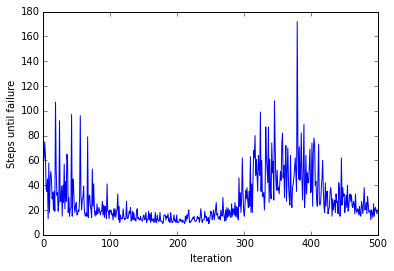

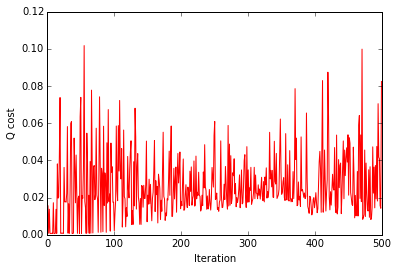

In [9]:
plt.figure(0)
plt.plot(steps)
plt.xlabel("Iteration")
plt.ylabel("Steps until failure")

plt.figure(1)
plt.plot(q_costs, "r")
plt.xlabel("Iteration")
plt.ylabel("Q cost")